In [8]:
import pandas
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Import the data file as a data frame
filepath = 'rushhr_coordinates.csv'
df = pandas.read_csv(filepath)

print(df.iloc[0:2])
print('Number of data points: '+str(len(df)))

   Unnamed: 0  pickup_longitude  pickup_latitude  dropoff_longitude  \
0     3220302        -73.984283        40.729012         -74.001923   
1     3220303        -73.955917        40.764046         -73.975967   

   dropoff_latitude  
0         40.721500  
1         40.765697  
Number of data points: 80958


In [ ]:
#Come up with a bounding box for the city
angle = 36
width =


fig=plt.figure(figsize=(18, 16))
#plt.axis('equal')
plt.plot(df['pickup_x'],df['pickup_y'],color='b',marker=',',lw=0, linestyle="")

In [186]:
def centerRotateScale(lon,lat,lonCenter=0,latCenter=0,rotationAngle=0,scale=1):
    '''
    Takes longitudes in terms of vertical numpy matrix and 
    latitude in terms of a vertical numpy matrix
    Re-centers at lonCenter and latCenter
    Rotates the coordinate sstem by rotationangle (in degrees)
    scales the final results by the scale
    '''
    #Center
    M = np.concatenate((lon-lonCenter, lat-latCenter), axis=1)
    #Make rotation matrix then rotate
    theta = math.radians(rotationAngle)
    R = np.matrix([[math.cos(theta), -1*math.sin(theta)],
                  [math.sin(theta), math.cos(theta)]])
    M = R*M.transpose()
    M.transpose()
    #Scale the values
    M = M*scale
    return M[0,:], M[1,:]
#Center the latitude and longitude around the bottom left of manhattan
#(40.7083,-74.0520)


In [226]:
#Center the latitude and longitude around times square
#Rotate the graph by 29 degrees, because that is the angle of manhattan
lon = df.as_matrix(['pickup_longitude'])
lat = df.as_matrix(['pickup_latitude'])
x,y = centerRotateScale(lon,lat,lonCenter=-73.985101,latCenter=40.759080,rotationAngle=36,scale=100)
#Save the x and the y to the data frame
df['pickup_x'] = x.tolist()[0]
df['pickup_y'] = y.tolist()[0]
#Rotate the graph by 29 degrees, because that is the angle of manhattan
lon = df.as_matrix(['dropoff_longitude'])
lat = df.as_matrix(['dropoff_latitude'])
x,y = centerRotateScale(lon,lat,lonCenter=-73.985101,latCenter=40.759080,rotationAngle=36,scale=100)
#Save the x and the y to the data frame
df['dropoff_x'] = x.tolist()[0]
df['dropoff_y'] = y.tolist()[0]

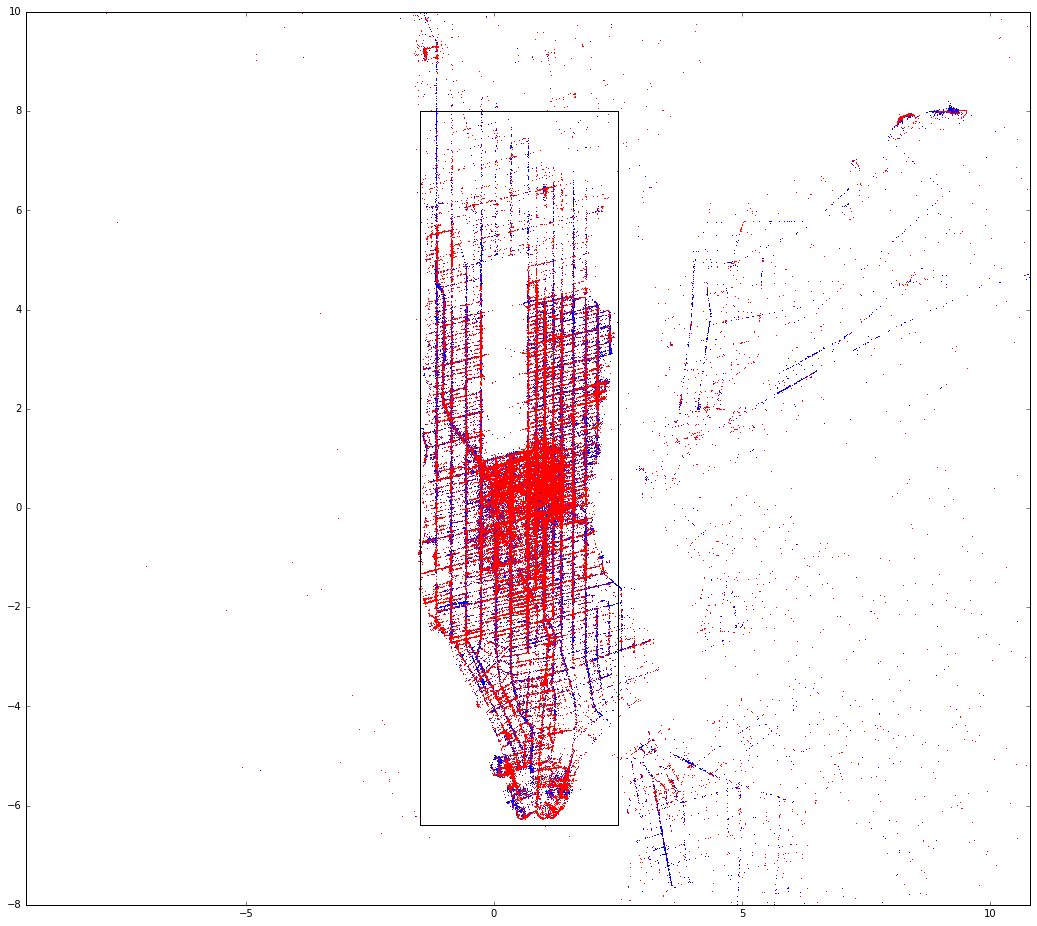

In [227]:
deltax = [-1.5,2.5]
deltay = [-6.4,8]

boxx = [deltax[0],deltax[0],deltax[1],deltax[1],deltax[0]]
boxy = [deltay[0],deltay[1],deltay[1],deltay[0],deltay[0]]


fig=plt.figure(figsize=(18, 16))
plt.axis('equal')
plt.plot(df['pickup_x'],df['pickup_y'],color='b',marker=',',lw=0, linestyle="")
plt.plot(df['dropoff_x'],df['dropoff_y'],color='r',marker=',',lw=0, linestyle="")
plt.plot(boxx,boxy,'K')
if True:
    plt.xlim([-1.25*minusx,1.25*plusx])
    plt.ylim([-1.25*minusy,1.25*plusy])